# Holmes using USCRN insitu data
We will try to recreate the results from Holmes et. al. by studying the linear relationship between LST and Ka(H) brightness temperature.

We have all stations from the USCRN network LST(lat,lon,time)

* Test Holmes' hypothesis using each station individually.  

* Test it using data from all stations in a given moment in time.  

* Test it using all data from all stations.

$$ HolmesLST(Ka_H) = a * Ka_H + b $$
$$ a = 1.11 $$
$$ b = -15.2 $$


In [12]:
# Libraries
from ismn.interface import ISMN_Interface
import numpy as np
import matplotlib.pyplot as plt 

# Custom functions


# Global
%matplotlib inline

data_path = "../data/raw/Data_separate_files_header_20170101_20171231_10665_aY1v_20231116.zip"
selected_network = "USCRN"

lst = "surface_temperature"

In [13]:
ismn_data = ISMN_Interface(data_path, parallel=True)

Found existing ismn metadata in ../data/raw/python_metadata/Data_separate_files_header_20170101_20171231_10665_aY1v_20231116.csv.


In [30]:
# Get the ids for the USCRN network and subset from the whole dataset
ids = ismn_data.get_dataset_ids(variable='surface_temperature',
                                filter_meta_dict={'network': selected_network}
                                )
uscrn_data = ismn_data.subset_from_ids(ids)

Found existing ismn metadata in ../data/raw/python_metadata/Data_separate_files_header_20170101_20171231_10665_aY1v_20231116.csv.


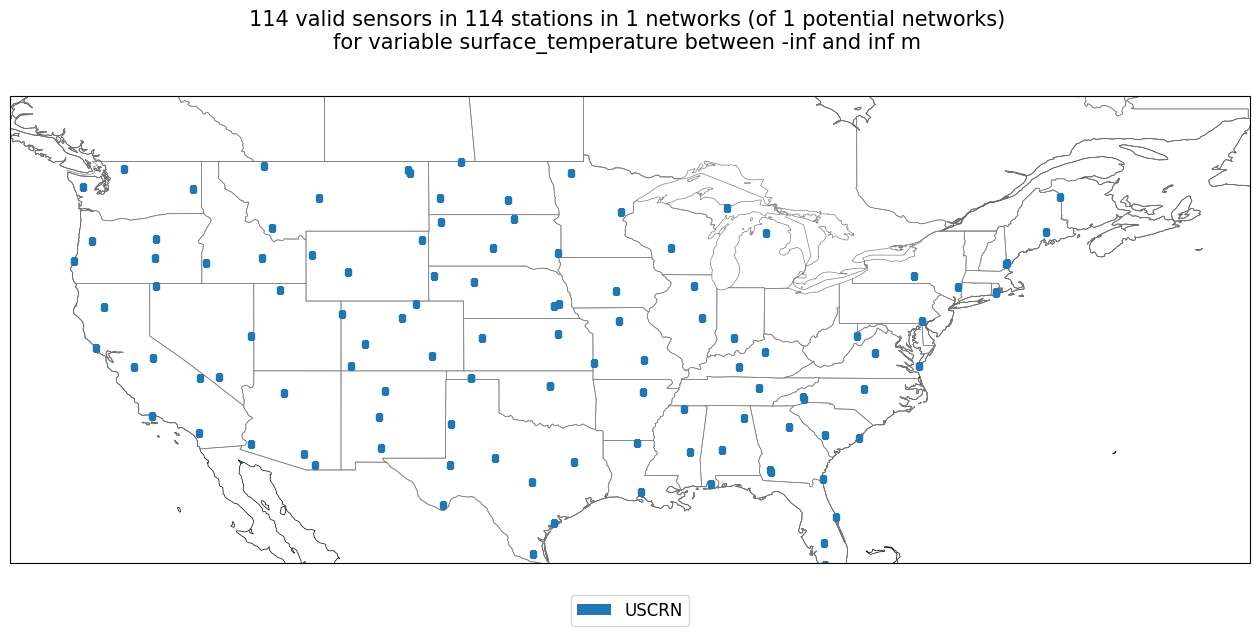

In [31]:
# We can even plot station locations 
import cartopy.crs as ccrs
#plot available station on a map
fig, ax = plt.subplots(1, 1, figsize=(16,10), subplot_kw={'projection': ccrs.PlateCarree()})
uscrn_data.plot_station_locations('surface_temperature', ax=ax, markersize=5, text_scalefactor=3)
ax.set_extent([-128, -57, 26, 47]) # US aproximate coordinate range
plt.show()

Valid Sensors:  37


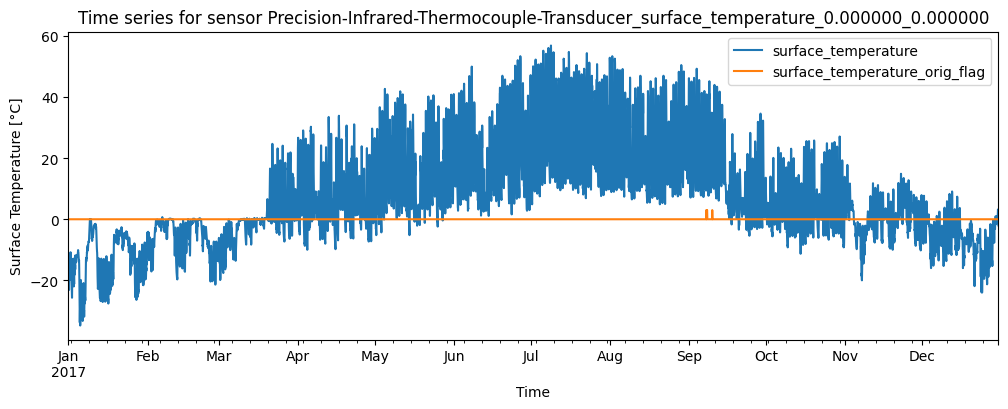

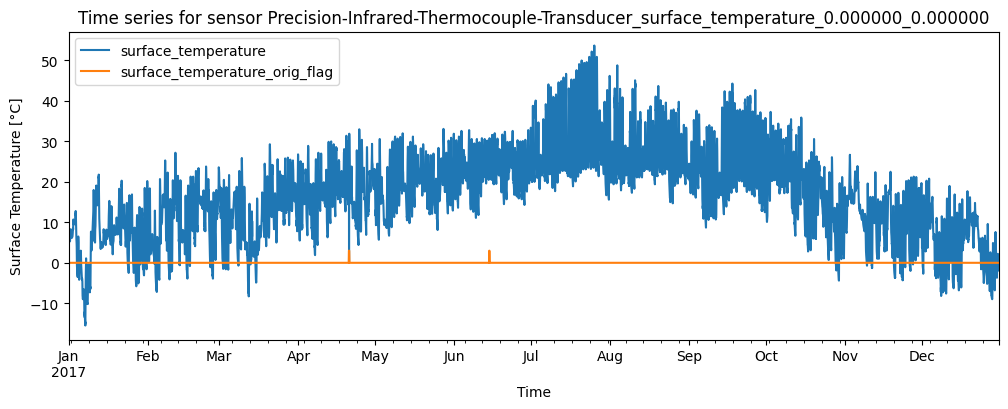

In [34]:
i = 0
m = 0
for network, station, sensor in uscrn_data.collection.iter_sensors(variable='surface_temperature', depth = [0,0.05]):
# Select for sensors with valid data ranges (°C)
    if np.min(sensor.data["surface_temperature"]) > -100:
        m +=1
        if i < 2: # Print only 3 stations that have good data
            ax = sensor.data.plot(figsize=(12,4), title=f'Time series for sensor {sensor.name}')
            ax.set_xlabel("Time")
            ax.set_ylabel("Surface Temperature [°C]")
            i+=1


print('Valid Sensors: ', m)

In [ ]:
# Recover the data only from the sensors that have good timeseries.

